In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 

## 0. Fitness function - Visualisation
We have chosen the Rastragin for our fitness function

In [2]:
def rastrigin(X, A=10):
    return A*len(X) + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in X])

In [3]:
def plot():
    X = np.linspace(-5, 5, 200)    
    Y = np.linspace(-5, 5, 200)    

    X, Y = np.meshgrid(X, Y)

    Z = rastrigin([X, Y], A=10)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.hsv, linewidth=0, antialiased=False)    
    plt.savefig('rastrigin.png')

/tmp/ipykernel_64826/1877137183.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


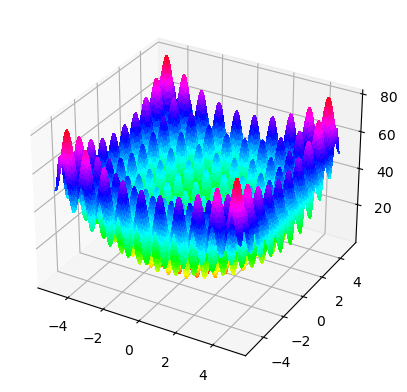

In [4]:
plot()

In [5]:
def plot_heatmap():
    X = np.linspace(-5, 5, 200)    
    Y = np.linspace(-5, 5, 200)    

    X, Y = np.meshgrid(X, Y)

    Z = rastrigin([X, Y])

    plt.imshow(Z, cmap='hot', extent=[-5, 5, -5, 5])
    plt.colorbar()
    plt.savefig('rastrigin_heatmap.png')


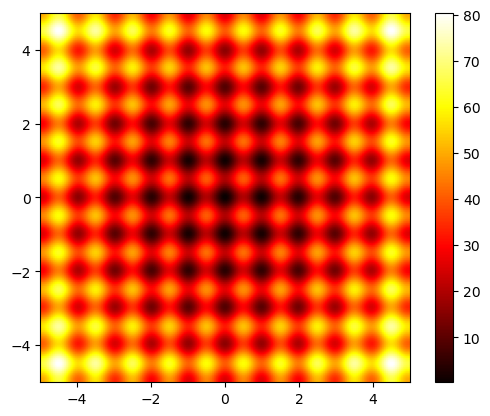

In [6]:
plot_heatmap()

### Ploting path
Define a function for plotting the path a single particle has followed to reach a global minimum

In [81]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_path(path):
    xs = [p[0] for p in path]
    ys = [p[1] for p in path]
    zs = [p[2] for p in path]

    # plot the path
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(xs, ys, zs, label='path')
    ax.legend()
    plt.savefig('rastrigin_path.png')

def plot_path_heatmap(path):
    xs = [p[0] for p in path]
    ys = [p[1] for p in path]
    zs = [p[2] for p in path]

    # plot the path
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(xs, ys, label='path')
    ax.legend()
    plt.savefig('rastrigin_path_heatmap.png')


## 1. Particle class

In [89]:
class Particle:
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=minx, high=maxx, size=dim)
        self.best_part_pos = self.position
        self.dim = dim
        self.path = []

        self.fitness = rastrigin(self.position)
        self.best_part_fitness = self.fitness

    def setPos(self, pos):
        self.position = pos
        self.fitness = rastrigin(self.position)
        self.path.append(pos)

        #Update personal best
        if self.fitness < self.best_part_fitness:
            self.best_part_fitness = self.fitness
            self.best_part_pos = pos 
    
    def updateVelocity(self, inertia, a1, a2, best_swarm_pos):
        cur_vel = self.velocity
        #Use random vectors r1 and r2 for doing stochastic process
        r1 = np.random.uniform(low=0, high=1, size=self.dim)
        r2 = np.random.uniform(low=0, high=1, size=self.dim)
        #Calculate new velocity using the following formulae
        new_vel = inertia * cur_vel + a1 * r1 * (self.best_part_pos - self.position) + a2 * r2 * (best_swarm_pos - self.position)
        self.velocity = new_vel
        return new_vel

## 2. PSO algorithm

In [90]:
class PSO:
    def __init__(self, w, a1, a2, dim, population_size, time_steps, search_range):
        self.w = w #Inertia
        self.a1 = a1 #Attraction to personal best
        self.a2 = a2 #Attraction to global best
        self.dim = dim
        self.population_size = population_size
        self.time_steps = time_steps
        self.search_range = search_range

        self.swarm = [Particle(dim, -search_range, search_range) for i in range(population_size)]
        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e50

    def run(self):
        for t in range(self.time_steps):
            for p in self.swarm:
                new_position = p.position + p.updateVelocity(self.w, self.a1, self.a2, self.best_swarm_pos)
                #Check if the new position is within the search space
                if new_position@new_position > 1.0e+18:
                    print(f"Time: {t} => Best Position: {self.best_swarm_pos}, Best Fit: {self.best_swarm_fitness}")
                    raise SystemExit('Most likely divergent => Decrease parameter values')
                
                p.setPos(new_position)
                new_fitness = rastrigin(new_position)

                #Update global best if a better solution is found
                if new_fitness < self.best_swarm_fitness:
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position

            if t%100 == 0:
                print(f"Time: {t} => Best Position: {self.best_swarm_pos}, Best Fit: {self.best_swarm_fitness}")
        # plot_path(self.swarm[0].path)
        # plot_path_heatmap(self.swarm[0].path)
        return self.best_swarm_pos, self.best_swarm_fitness

Time: 0 => Best Position: [11.60154414  3.05552874  4.4457094  10.81799009  6.63486249 -3.66418256], Best Fit: 413.8429948814422
Time: 100 => Best Position: [-8.76179086e-01  2.04484686e+00  1.04137059e+00 -1.01781337e-03
  1.10650297e+00  9.80161054e-01], Best Fit: 14.060149975231454
Time: 200 => Best Position: [-0.91103616  2.04499645  1.04143103 -0.03043301  1.09657455  1.01841018], Best Fit: 12.627370175948357
Time: 300 => Best Position: [-0.98563103  0.99550951  1.01840789  0.01769303  0.98702127  1.00774518], Best Fit: 5.208055250585879
Time: 400 => Best Position: [-0.99373331  0.99384607  1.00979697 -0.00678919  0.98881879  1.00090318], Best Fit: 5.042632651489114
Time: 500 => Best Position: [-0.00818006  0.99875328  0.9898565  -0.01192864  0.98961844  0.96926046], Best Fit: 4.165440209290466
Time: 600 => Best Position: [-0.03422335  0.99148875  0.99366003  0.02785763  0.99205398 -0.02264648], Best Fit: 3.4758941394029392
Time: 700 => Best Position: [-1.83260503e-04  9.84704180e

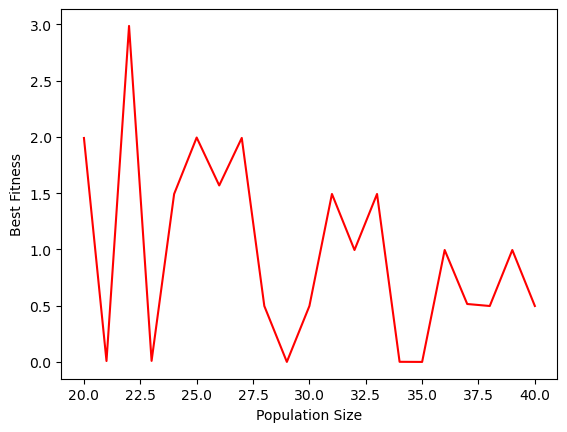

In [131]:
import matplotlib.pyplot as plt

population_sizes = [x for x in range(20,41)]
best_fitnesses = []


for population_size in population_sizes:
    fit = 0
    for i in range(2):
        best_pos, best_fit = PSO(dim=6, w=0.7, a1=2.02, a2=2.02, population_size=population_size, time_steps=1001, search_range=2.5).run()
        fit += best_fit
    best_fitnesses.append(fit/2)

plt.plot(population_sizes, best_fitnesses,'-r')
plt.xlabel('Population Size')
plt.ylabel('Best Fitness')
plt.show()